<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%9D%D0%A1_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание Light



Напишите классификацию заболеваний по базе симптомов, используя любые подходы, связанные с обработкой текстов.

1. Embedding + LSTM сеть.
2. Embedding + Conv1D сеть.
3. Embedding + сложная сеть из Dense, LSTM и Conv1D.

Добейтесь максимальной точности распознавания.

Используйте xLen = 50.

# библиотеки и тексты болячек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import  Sequential
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, LSTM, Bidirectional
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import files
from google.colab import drive
%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q '/content/drive/MyDrive/Болезни-20211118T231230Z-001.zip' -d '/content/texts'

# Подготовка данных

In [ ]:
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace('\n', ' ')
  return text

In [ ]:
trainText = []
trainText.append(readText('/content/texts/Болезни/Аппендицит.txt'))
trainText.append(readText('/content/texts/Болезни/Гастрит.txt'))
trainText.append(readText('/content/texts/Болезни/Гепатит.txt'))
trainText.append(readText('/content/texts/Болезни/Дуоденит.txt'))
trainText.append(readText('/content/texts/Болезни/Колит.txt'))
trainText.append(readText('/content/texts/Болезни/Панкреатит.txt'))
trainText.append(readText('/content/texts/Болезни/Холицестит.txt'))
trainText.append(readText('/content/texts/Болезни/Эзофагит.txt'))
trainText.append(readText('/content/texts/Болезни/Энтерит.txt'))
trainText.append(readText('/content/texts/Болезни/Язва.txt'))

In [ ]:
className = ['Аппендицит', 'Гастрит', 'Гепатит', 'Дуоденит', 'Колит', 'Панкреатит', 'Холицестит', 'Эзофагит', 'Энтерит', 'Язва']
nClasses = len(className)
maxWordsCount = 20000

In [ ]:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0\ufeff', lower=True,
                      split = ' ', oov_token = 'unknown', char_level = False)
tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items())

In [ ]:
print(tokenizer.word_index.items())

dict_items([('unknown', 1), ('в', 2), ('и', 3), ('боль', 4), ('тошнота', 5), ('или', 6), ('рвота', 7), ('боли', 8), ('живота', 9), ('при', 10), ('животе', 11), ('после', 12), ('области', 13), ('отрыжка', 14), ('с', 15), ('слабость', 16), ('аппетита', 17), ('во', 18), ('тела', 19), ('изжога', 20), ('вздутие', 21), ('может', 22), ('снижение', 23), ('пищи', 24), ('повышение', 25), ('температуры', 26), ('рту', 27), ('еды', 28), ('диарея', 29), ('на', 30), ('иногда', 31), ('до', 32), ('к', 33), ('метеоризм', 34), ('температура', 35), ('подреберье', 36), ('верхней', 37), ('части', 38), ('не', 39), ('правом', 40), ('стул', 41), ('потеря', 42), ('чувство', 43), ('общая', 44), ('эпигастральной', 45), ('желудка', 46), ('урчание', 47), ('–', 48), ('ощущение', 49), ('отсутствие', 50), ('ощущения', 51), ('понос', 52), ('нарушение', 53), ('позывы', 54), ('тяжести', 55), ('которая', 56), ('запор', 57), ('время', 58), ('приема', 59), ('кожи', 60), ('могут', 61), ('появление', 62), ('повышенная', 63), 

In [ ]:
print('размер:', len(tokenizer.word_index.items()))
print(len(items))

размер: 1999
1999


In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
print(" текст: ", trainText[1] [180:280])
print("последовательность индексов: ", trainWordIndexes[1][20:50])

 текст:  я или острая жгучая боль в верхней части живота; ощущение переполненности в верхней части живота пос
последовательность индексов:  [64, 20, 112, 6, 100, 186, 4, 2, 37, 38, 9, 49, 272, 2, 37, 38, 9, 12, 28, 16, 113, 7, 50, 17, 34, 14, 42, 93, 102, 155]


In [ ]:
def getSetFromIndexes(wordIndexes, xlen, step): # образуем цепочки xLen с шагом step
  xSample = []
  wordslen = len(wordIndexes)
  index = 0
  while (index + xlen <= wordslen):
    xSample.append(wordIndexes[index:index + xlen])
    index+=step
  return xSample

In [ ]:
def createSetMultiClasses(wordIndexes, xlen, step):
  nClasses = len(wordIndexes)
  classesXSample = []
  for WI in wordIndexes:
    classesXSample.append(getSetFromIndexes(WI, xlen, step))
  xSamples = []
  ySamples = []
  for t in range(nClasses):
    xT = classesXSample[t]
    for i in range(len(xT)):
      xSamples.append(xT[i])
      ySamples.append(utils.to_categorical(t, nClasses))
  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)
  return (xSamples, ySamples)

In [ ]:
xLen = 50
step = 5
xTrain, yTrain = createSetMultiClasses(trainWordIndexes, xLen, step)
print(xTrain.shape)
print(yTrain.shape)

(1551, 50)
(1551, 10)


In [ ]:
x_Train, x_Test, y_Train, y_Test = train_test_split(xTrain, yTrain, test_size=0.1, shuffle=True)

# Embedding + LSTM

In [ ]:
model = Sequential()
model.add(Embedding(maxWordsCount, 10, input_length=xLen))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(6))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))


In [ ]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy'] )

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 50, 10)            200000    
                                                                 
 spatial_dropout1d_29 (Spati  (None, 50, 10)           0         
 alDropout1D)                                                    
                                                                 
 lstm_22 (LSTM)              (None, 6)                 408       
                                                                 
 flatten_23 (Flatten)        (None, 6)                 0         
                                                                 
 dense_33 (Dense)            (None, 10)                70        
                                                                 
Total params: 200,478
Trainable params: 200,478
Non-trainable params: 0
_______________________________________________

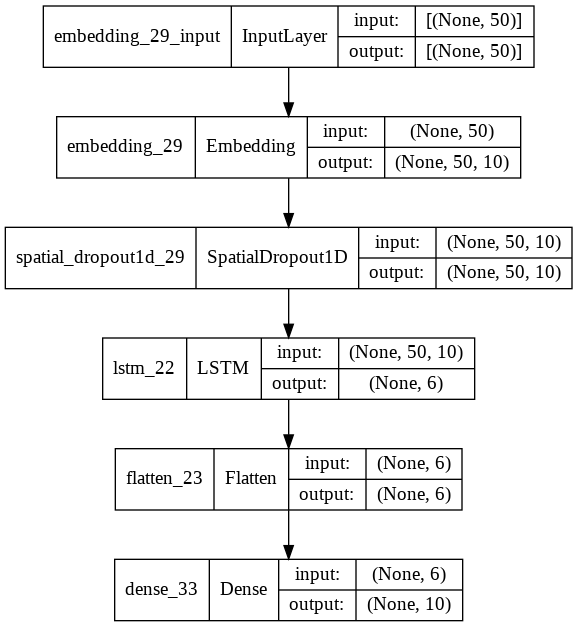

In [ ]:
model.summary()
plot_model(model, show_shapes=True, dpi=96)

In [ ]:
history = model.fit(x_Train, y_Train, batch_size=64, epochs=100, validation_data=(x_Test, y_Test))

Epoch 1/100
22/22 [==============================] - 1s 29ms/step - loss: 0.4872 - accuracy: 0.7591 - val_loss: 0.5092 - val_accuracy: 0.7179
Epoch 2/100
22/22 [==============================] - 1s 29ms/step - loss: 0.4921 - accuracy: 0.7556 - val_loss: 0.5054 - val_accuracy: 0.7436
Epoch 3/100
22/22 [==============================] - 1s 28ms/step - loss: 0.4777 - accuracy: 0.7835 - val_loss: 0.5207 - val_accuracy: 0.7564
Epoch 4/100
22/22 [==============================] - 1s 29ms/step - loss: 0.4803 - accuracy: 0.8315 - val_loss: 0.4967 - val_accuracy: 0.7564
Epoch 5/100
22/22 [==============================] - 1s 27ms/step - loss: 0.4753 - accuracy: 0.8244 - val_loss: 0.4825 - val_accuracy: 0.7949
Epoch 6/100
22/22 [==============================] - 1s 28ms/step - loss: 0.4657 - accuracy: 0.8387 - val_loss: 0.4828 - val_accuracy: 0.8013
Epoch 7/100
22/22 [==============================] - 1s 30ms/step - loss: 0.4535 - accuracy: 0.8545 - val_loss: 0.4748 - val_accuracy: 0.8397
Epoch 

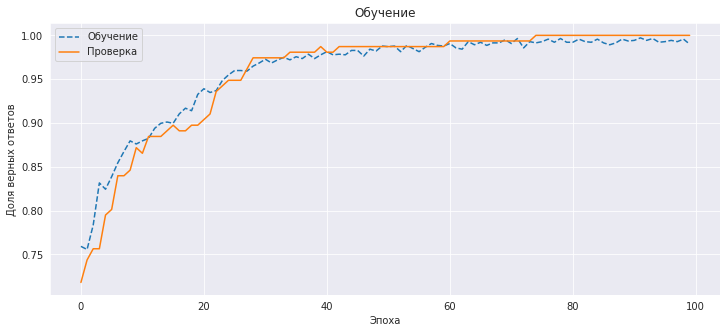

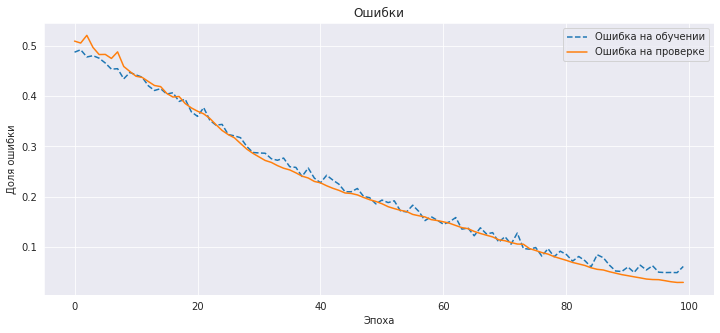

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Обучение')
plt.plot(history.history['accuracy'], '--', label = 'Обучение')
plt.plot(history.history['val_accuracy'], label = 'Проверка')
plt.xlabel('Эпоха')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
plt.figure(figsize=(12,5))
plt.title('Ошибки')
plt.plot(history.history['loss'], '--', label = 'Ошибка на обучении')
plt.plot(history.history['val_loss'], label = 'Ошибка на проверке')
plt.xlabel('Эпоха')
plt.ylabel('Доля ошибки')
plt.legend()
plt.show()

ВЫВОД: если ещё раз запущу, то мне с пятой эпохе покажет 100%. Запущено 100 эпох. В принципе она выйдет на 100%, показывает хороший рост. Долго запрягает,  но даёт хороший результат.

In [ ]:
score = model.evaluate(x_Test, y_Test,)

5/5 [==============================] - 0s 6ms/step - loss: 0.0298 - accuracy: 1.0000


вот не заходит мне, обработка текстов⚡⛳

# Embedding + Conv1D

In [ ]:
modelEC = Sequential()
modelEC.add(Embedding(maxWordsCount, 10, input_length=xLen))
modelEC.add(SpatialDropout1D(0.1))
modelEC.add(Conv1D(20, 5, activation='relu', padding='same'))
modelEC.add(MaxPooling1D(2))
modelEC.add(Flatten())
modelEC.add(Dense(10, activation='softmax'))

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 50, 10)            200000    
                                                                 
 spatial_dropout1d_30 (Spati  (None, 50, 10)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_16 (Conv1D)          (None, 50, 20)            1020      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 25, 20)           0         
 g1D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 500)               0         
                                                                 
 dense_34 (Dense)            (None, 10)              

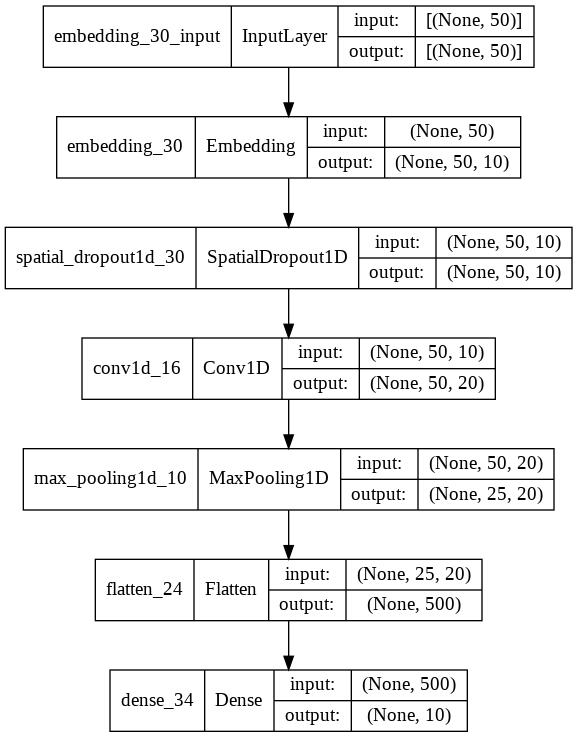

In [ ]:
modelEC.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
modelEC.summary()
plot_model(modelEC, show_shapes=True, dpi=96)

In [ ]:
historyEC = modelEC.fit(x_Train, y_Train, batch_size=64, epochs=30, validation_data=(x_Test, y_Test))

Epoch 1/30
22/22 [==============================] - 2s 20ms/step - loss: 2.2637 - accuracy: 0.1778 - val_loss: 2.1996 - val_accuracy: 0.2244
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 2.1889 - accuracy: 0.1814 - val_loss: 2.1115 - val_accuracy: 0.2244
Epoch 3/30
22/22 [==============================] - 0s 10ms/step - loss: 2.0790 - accuracy: 0.1821 - val_loss: 1.9451 - val_accuracy: 0.2244
Epoch 4/30
22/22 [==============================] - 0s 10ms/step - loss: 1.9083 - accuracy: 0.2229 - val_loss: 1.7277 - val_accuracy: 0.2821
Epoch 5/30
22/22 [==============================] - 0s 10ms/step - loss: 1.7063 - accuracy: 0.3613 - val_loss: 1.4995 - val_accuracy: 0.5513
Epoch 6/30
22/22 [==============================] - 0s 10ms/step - loss: 1.4725 - accuracy: 0.5634 - val_loss: 1.2486 - val_accuracy: 0.6346
Epoch 7/30
22/22 [==============================] - 0s 11ms/step - loss: 1.2409 - accuracy: 0.6961 - val_loss: 1.0192 - val_accuracy: 0.7179
Epoch 8/30
22

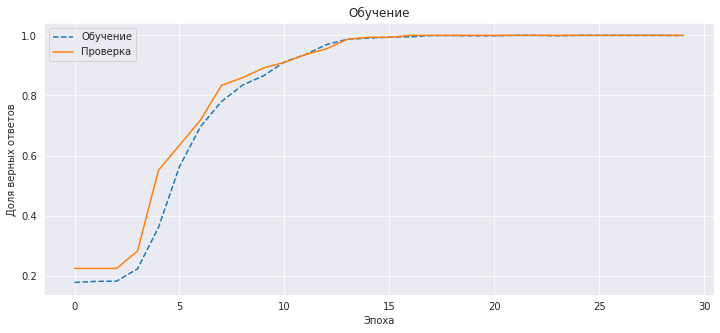

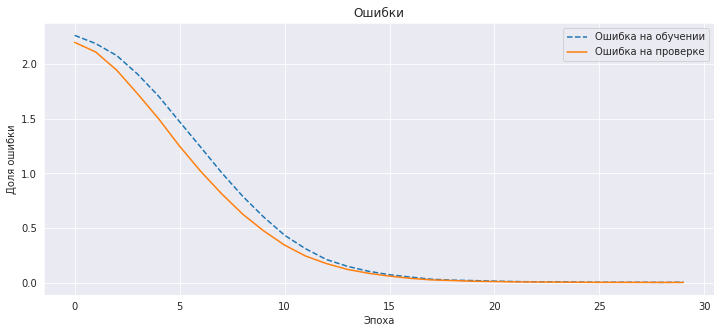

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Обучение')
plt.plot(historyEC.history['accuracy'], '--', label = 'Обучение')
plt.plot(historyEC.history['val_accuracy'], label = 'Проверка')
plt.xlabel('Эпоха')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
plt.figure(figsize=(12,5))
plt.title('Ошибки')
plt.plot(historyEC.history['loss'], '--', label = 'Ошибка на обучении')
plt.plot(historyEC.history['val_loss'], label = 'Ошибка на проверке')
plt.xlabel('Эпоха')
plt.ylabel('Доля ошибки')
plt.legend()
plt.show()

ВЫВОД: тут и так видно, что модель показывает 100% уже 14 эпохе. Быстро и сердито.

# Embedding + сложная сеть из Dense, LSTM и Conv1D.

In [ ]:
modelDLC = Sequential()
modelDLC.add(Embedding(maxWordsCount, 10, input_length=xLen ))
modelDLC.add(SpatialDropout1D(0.1))
modelDLC.add(Dense(100, activation='relu'))
modelDLC.add(LSTM(6, return_sequences=1))#  а тут без второго параметра не работает

modelDLC.add(Conv1D(20, 5, activation='relu'))
modelDLC.add(MaxPooling1D(2))
modelDLC.add(Flatten())
modelDLC.add(Dense(10, activation='softmax'))


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 50, 10)            200000    
                                                                 
 spatial_dropout1d_31 (Spati  (None, 50, 10)           0         
 alDropout1D)                                                    
                                                                 
 dense_35 (Dense)            (None, 50, 100)           1100      
                                                                 
 lstm_23 (LSTM)              (None, 50, 6)             2568      
                                                                 
 conv1d_17 (Conv1D)          (None, 46, 20)            620       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 23, 20)           0         
 g1D)                                                

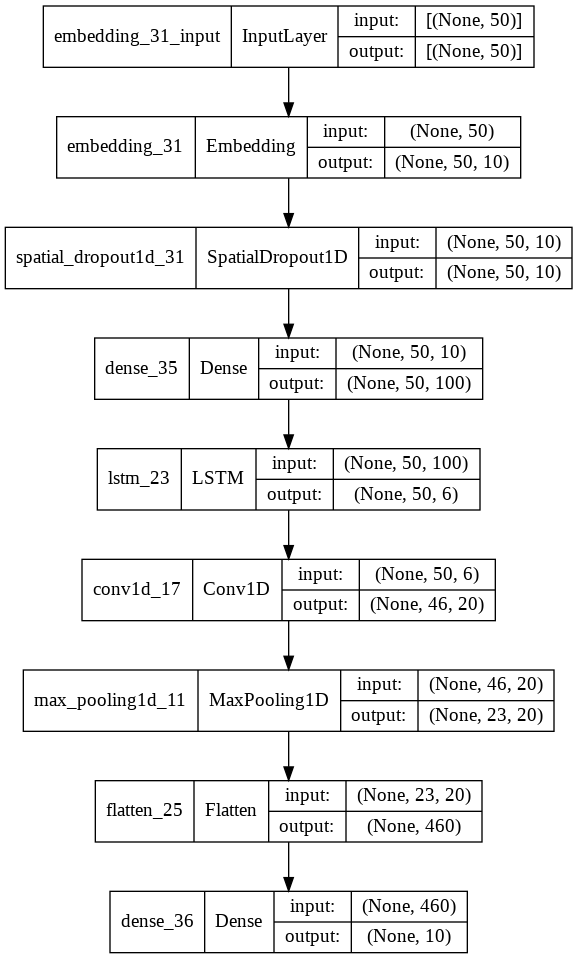

In [ ]:
modelDLC.summary()
plot_model(modelDLC, show_shapes=True, dpi=96)

In [ ]:
modelDLC.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historyDLC = modelDLC.fit(x_Train, y_Train, batch_size=64, epochs=30, validation_data=(x_Test, y_Test))

Epoch 1/30
22/22 [==============================] - 1s 41ms/step - loss: 0.1486 - accuracy: 0.9462 - val_loss: 0.1639 - val_accuracy: 0.9295
Epoch 2/30
22/22 [==============================] - 1s 39ms/step - loss: 0.1145 - accuracy: 0.9606 - val_loss: 0.1086 - val_accuracy: 0.9872
Epoch 3/30
22/22 [==============================] - 1s 38ms/step - loss: 0.1304 - accuracy: 0.9606 - val_loss: 0.1125 - val_accuracy: 0.9487
Epoch 4/30
22/22 [==============================] - 1s 40ms/step - loss: 0.1445 - accuracy: 0.9513 - val_loss: 0.1011 - val_accuracy: 0.9679
Epoch 5/30
22/22 [==============================] - 1s 38ms/step - loss: 0.0925 - accuracy: 0.9756 - val_loss: 0.3464 - val_accuracy: 0.8333
Epoch 6/30
22/22 [==============================] - 1s 40ms/step - loss: 0.1359 - accuracy: 0.9527 - val_loss: 0.0746 - val_accuracy: 0.9872
Epoch 7/30
22/22 [==============================] - 1s 37ms/step - loss: 0.1290 - accuracy: 0.9577 - val_loss: 0.1512 - val_accuracy: 0.9423
Epoch 8/30
22

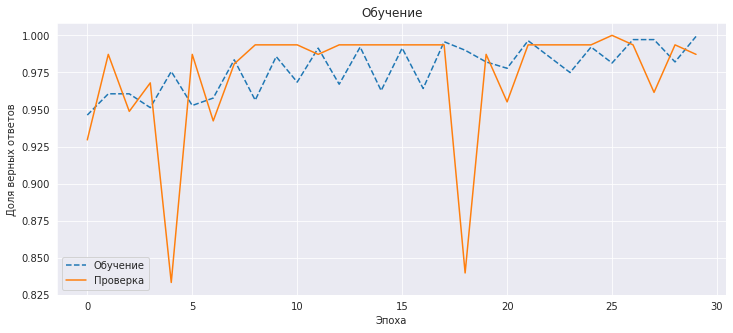

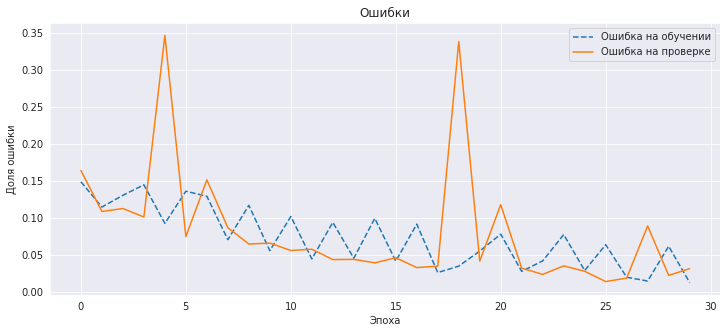

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Обучение')
plt.plot(historyDLC.history['accuracy'], '--', label = 'Обучение')
plt.plot(historyDLC.history['val_accuracy'], label = 'Проверка')
plt.xlabel('Эпоха')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
plt.figure(figsize=(12,5))
plt.title('Ошибки')
plt.plot(historyDLC.history['loss'], '--', label = 'Ошибка на обучении')
plt.plot(historyDLC.history['val_loss'], label = 'Ошибка на проверке')
plt.xlabel('Эпоха')
plt.ylabel('Доля ошибки')
plt.legend()
plt.show()

ВЫВОД: данная модель тоже показала отличный результат, хоть и дёрнулась на 4 и 17 эпохе. 



---
 **ОБЩИЙ ВЫВОД:** Все модели повели себя с очень хорошей стороны. При одинаковом количестве всех параметров ~200 000  показали высокую вероятность опознавания. Но первая модель , хоть и показала себя хорошо но проигрывает в количестве эпох обучения. При перемешивании(shuffle) первая и третья показывает не всегда высокие значения, а вот вторая Эмбэддинг и свёртка показывает всегда результат на отлично.
